# Text Preprocessing Basics (SMS Spam)

## Objetives


*   Load the sms_spam Dataset (Hugging Face Datasets)
*   Inspect the data (Class balance, text length, examples)
*   Build a reusable preprocessing pipeline using spaCy
*   Compare raw vs cleaned text and quantify the impact (vocab size, legth)

In [2]:
'''
Use this cell if you run the notebook in a fresh environment
'''

# If you're in Colab or a fresh venv, uncomment:
!pip -q install datasets spacy pandas numpy matplotlib scikit-learn

# Download spaCy English model (small, good for demos)
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
'''
Imports basic libraries
'''
import re
import unicodedata
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
import spacy

In [4]:
dataset = load_dataset('sms_spam')
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [5]:
df_sms = pd.DataFrame(dataset['train'])
df_sms.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## Data Schema


*   sms => message text
*   label => 0 ham (not sapam), 1 spam



In [6]:
print("Shape: ", df_sms.shape)
print("Column: ", list(df_sms.columns))
print("Missing Vlaues: \n", df_sms.isna().sum())

df_sms["label"].value_counts()

Shape:  (5574, 2)
Column:  ['sms', 'label']
Missing Vlaues: 
 sms      0
label    0
dtype: int64


,count
label,
0,4827
1,747


<function matplotlib.pyplot.show(close=None, block=None)>

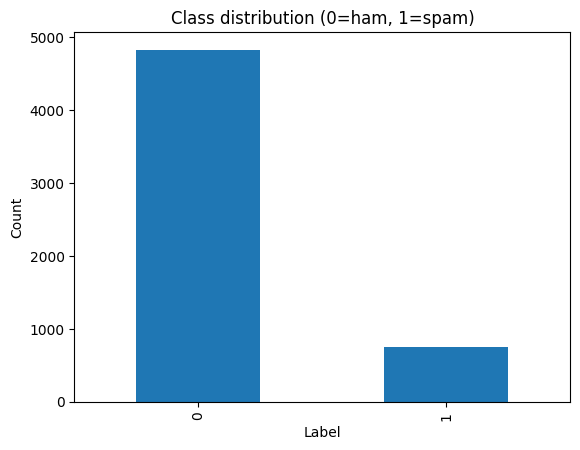

In [9]:
ax = df_sms["label"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Class distribution (0=ham, 1=spam)")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
plt.show

In [10]:
df_sms.sample(5, random_state=42)[["label", "sms"]]

,label,sms
3690,0,You still coming tonight?\n
3527,0,"""HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE..."
724,0,Ya even those cookies have jelly on them\n
3370,0,Sorry i've not gone to that place. I.ll do so ...
468,0,When are you going to ride your bike?\n


In [11]:
'''
Text Length Analysis
'''
df_sms["char_len"] = df_sms["sms"].str.len()
df_sms["word_len"] = df_sms["sms"].str.split().apply(len)

df_sms[["char_len", "word_len"]].describe()

,char_len,word_len
count,5574.000000,5574.000000
mean,81.478292,15.591676
std,59.848302,11.390454
min,3.000000,1.000000
25%,37.000000,7.000000
50%,63.000000,12.000000
75%,123.000000,23.000000
max,911.000000,171.000000


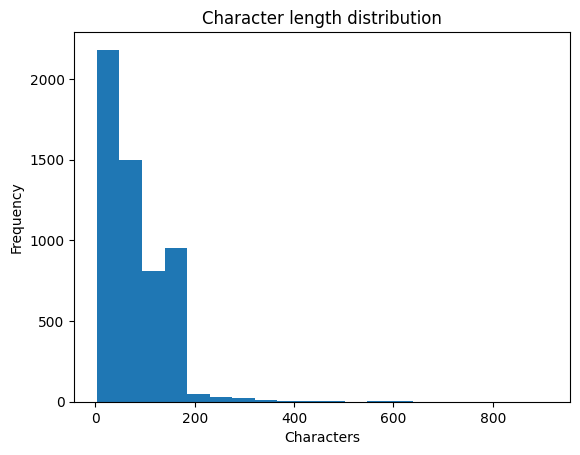

In [13]:
ax = df_sms["char_len"].plot(kind="hist", bins = 20)
ax.set_title("Character length distribution")
ax.set_xlabel("Characters")
plt.show()

In [15]:
'''
Compare length by class
'''

df_sms.groupby("label")[["char_len", "word_len"]].mean()

,char_len,word_len
label,,
0,72.471929,14.304123
1,139.676037,23.911647


## Preprocessing Pipeline (spaCy)

* Normalize unicode
* Lowecase
* Remove URL's / emails
* Replace numbers with a placeholder token
* Tokenize with spaCy
* Keep alphabetic tokens and select placeholders
* Lemmatize
* Remove Stopwords
* Join back into a "cleanned text" string

Lemmatization reduces inflections (running - run) usuallt improves generalization for classical ML features (TF-IDF)

In [16]:
# Disable components we don't need for speed (we mainly need tokenizer + lemmatizer)
nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat"])

# Make sure the pipeline has a lemmatizer available (en_core_web_sm includes it)
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [21]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
MULTISPACE_RE = re.compile(r"\s+")

def normalize_unicode(text: str) -> str:
    #NFKC normalization makes unicode forms cossitent
    return unicodedata.normalize("NFKC", text)

def basic_clean(text: str, replace_numbers: bool = True) -> str:
    text = normalize_unicode(text)
    text = text.lower()
    text = URL_RE.sub(" <URL> ", text)
    text = EMAIL_RE.sub(" <EMAIL> ", text)
    if replace_numbers:
      text = re.sub(r"\b\d+\b", "<NUM>", text)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text


## spaCy-based Tokenizer + lemmatizer

In [24]:
def spacy_preprocess(
    text: str,
    keep_placeholder: bool = True,
    remove_stopwords: bool = True
) -> str:
    text = basic_clean(text, replace_numbers=True)
    doc = nlp(text)

    tokens = []
    for t in doc:
      #Keep placeholders as special tokens
      if keep_placeholder and t.text in {"<url>", "<email>", "<num>"}:
        tokens.append(t.text.upper)
        continue

      # Filter tokens: keep alphabetic tokens only (removes punctuation)
      if not t.is_alpha:
        continue

      # Remove stopwords (spaCy stopword list)
      if remove_stopwords and t.is_stop:
        continue

      #Lemmatize; fallback to token text if lemma is empty
      lemma = t.lemma_.strip()
      if not lemma:
        lemma = t.text

      tokens.append(lemma)
    return

In [26]:
sample = df_sms.sample(8, random_state=7).copy()
sample["cleaned"] = sample["sms"].apply(spacy_preprocess)
sample[["label", "sms", "cleaned"]]

,label,sms,cleaned
83,0,You will be in the place of that man\n,None
3119,0,R u saying i should re order the slippers cos ...,None
3065,0,Ok. How many should i buy.\n,None
246,0,Too late. I said i have the website. I didn't ...,None
1178,0,Just nw i came to hme da..\n,None
3492,0,Ok.\n,None
4654,0,Lol yes. But it will add some spice to your da...,None
4987,0,That's y u haf 2 keep me busy...\n,None


In [30]:
'''
Apply to the full dataset
'''
df_sms["cleaned"] = df_sms["sms"].apply(spacy_preprocess)
df_sms[["sms", "cleaned"]].head()


,sms,cleaned
0,"Go until jurong point, crazy.. Available only ...",None
1,Ok lar... Joking wif u oni...\n,None
2,Free entry in 2 a wkly comp to win FA Cup fina...,None
3,U dun say so early hor... U c already then say...,None
4,"Nah I don't think he goes to usf, he lives aro...",None


In [31]:
df_sms["clean_char_len"] = df_sms["cleaned"].str.len()
df_sms[["char_len", "clean_char_len"]].describe()


,char_len
count,5574.000000
mean,81.478292
std,59.848302
min,3.000000
25%,37.000000
50%,63.000000
75%,123.000000
max,911.000000


In [32]:
def simple_vocab(texts: pd.Series) -> set:
    vocab = set()
    for s in texts:
        for tok in str(s).split():
            vocab.add(tok)
    return vocab

raw_vocab = simple_vocab(df_sms["sms"].str.lower())
clean_vocab = simple_vocab(df_sms["cleaned"])

len(raw_vocab), len(clean_vocab)


(13627, 1)

In [33]:
def top_tokens(texts: pd.Series, n=20):
    c = Counter()
    for s in texts:
        c.update(str(s).split())
    return c.most_common(n)

print("Top tokens (raw):")
print(top_tokens(df_sms["sms"].str.lower(), 20))

print("\nTop tokens (cleaned):")
print(top_tokens(df_sms["cleaned"], 20))


Top tokens (raw):
[('to', 2237), ('i', 2217), ('you', 1921), ('a', 1433), ('the', 1328), ('u', 998), ('and', 968), ('is', 869), ('in', 859), ('my', 755), ('for', 703), ('your', 677), ('of', 614), ('me', 610), ('have', 571), ('call', 559), ('on', 521), ('are', 486), ('that', 470), ('it', 466)]

Top tokens (cleaned):
[('None', 5574)]


## Notes on production considerations



**Determinism**: the pipeline is rule-based + spaCy lemmatizer; behavior is stable across runs given the same model version.

**Speed**: for production you should use nlp.pipe() batching rather than .apply() row-by-row (we can optimize in a later notebook).

**Risk/Trade-offs**:

- Stopword removal may remove useful information (e.g., negation).

- Lemmatization can sometimes distort domain-specific terms.

- Replacing numbers can lose information if exact values matter.



## Conclusions
Summarize:

* What cleaning steps were applied

* How the vocabulary and length changed

* Why placeholders help for spam-like patterns

* What you would test next (TF-IDF baseline, then Transformers)